In [93]:
import pandas as pd
from os import listdir
from pandas.errors import EmptyDataError
from unidecode import unidecode
import seaborn as sns
import re
from wordcloud import WordCloud
from gensim.models import Word2Vec, KeyedVectors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance
from random import shuffle
import pickle
from itertools import combinations

sns.set(
    rc = {
        'figure.figsize': (10, 8)
    },
    style = 'darkgrid'
)

In [2]:
 df = pd.concat([
    pd.read_csv('data/concatenated/'+filename)
    for filename in
    listdir('data/concatenated')
])

# Dictionares

In [3]:
grouping_orders = {
    "website": {
        "columns_before": ['website', 'sentiment'],
        "groupby": ["website"],
        "columns_after": ['fakt', 'gazeta', 'wyborcza'] 
    },
    "brand": {
        "columns_before": ['brand', 'sentiment'],
        "groupby": ["brand"],
        "columns_after": ['agora', 'ringier'] 
    },
    "country": {
        "columns_before": ['country', 'sentiment'],
        "groupby": ["country"],
        "columns_after": ['de/ch', 'pl'] 
    }
}

In [4]:
brand_keys = {
    "pl": {
        "agora": ['wyborcza', 'gazeta']
    },
    "de/ch": {
        "ringier": ['fakt', 'onet', 'newsweek']
    },
    'us': {
        "discovery": ['tvn']
    },
    'ru': {
        "sjegodnia": ['sputnik']
    }
}

In [5]:
osoba = ['wzór', 'wróg'] # wzór, wróg, nieprzyjaciel
partia = ['postęp', 'zacofanie'] # rozwój, dobrobyt, 
poglad = ['swoboda', 'reżim'] # chaos, totalitaryzm, racjonalizm
kraj = ['sojusznik', 'wróg'] # ostoja, oaza, 
keyword_reference_words = {
    'najwyższy': {
        'types': ['country'],
        'references': ['sprawiedliwość', 'niesprawiedliwość'],
    },
    'imigranci': {
        'types': ['country', 'global'],
        'references': ['obywatele', 'terroryści'],
    },
    'ekologia': {
        'types': ['global'],
        'references': ['', ''],
    },
    'emigracja': {
        'types': ['country'],
        'references': ['szansa', 'ucieczka'],
    },
    'pis': {
        'types': ['country'],
        'references': partia,
    },
    'obywatelska': {
        'types': ['country'],
        'references': partia,
    },
    'duda': {
        'types': ['country'],
        'references': osoba,
    },
    'morawiecki': {
        'types': ['country'],
        'references': osoba,
    },
    'szydło': {
        'types': ['country'],
        'references': osoba,
    },
    'kaczyński': {
        'types': ['country'],
        'references': osoba,
    },
    'kwaśniewski': {
        'types': ['country'],
        'references': osoba,
    },
    'lewica': {
        'types': ['country'],
        'references': poglad,
    },
    'prawica': {
        'types': ['country'],
        'references': poglad,
    },
    'lgbt': {
        'types': ['global', 'country'],
        'references': ['tolerancja', ''],
    },
    'europa': {
        'types': ['global'],
        'references': ['unia', 'rozłam'],
    },
    'rosja': {
        'types': ['global', 'country'],
        'references': kraj,
    },
    'usa': {
        'types': ['global', 'country'],
        'references': kraj,
    },
    'premier': {
        'types': ['country'],
        'references': osoba,
    },
    'prezydent': {
        'types': ['country'],
        'references': osoba,
    },
    'opozycja': {
        'types': ['country'],
        'references': partia,
    },
    'rząd': {
        'types': ['country'],
        'references': partia,
    },
    'sejm': {
        'types': ['country'],
        'references': partia,
    },
    'polska': {
        'types': ['global', 'country'],
        'references': ['oaza', ''],
    },
    'putin': {
        'types': ['global', 'country'],
        'references': ['sojusznik', 'wróg'],
    },
    'trump': {
        'types': ['global', 'country'],
        'references': ['sojusznik', 'wróg'],
    },
    'ukraina': {
        'types': ['global', 'country'],
        'references': kraj,
    },
    'media': {
        'types': ['country'],
        'references': ['', ''],
    },
    'bank': {
        'types': ['global'],
        'references': ['bezpieczeństwo', 'wyzysk'],
    },
    'niemcy': {
        'types': ['global', 'country'],
        'references': kraj,
    },
    'papież': {
        'types': ['global'],
        'references': osoba,
    },
    'kościół': {
        'types': ['country'],
        'references': ['oparcie', 'firma'],
    },
    'korwin': {
        'types': ['country'],
        'references': osoba,
    },
    'rydzyk': {
        'types': ['country'],
        'references': osoba,
    },
    'feminizm': {
        'types': ['country', 'global'],
        'references': ['równość', 'patriarchat'],
    },
    'miller': {
        'types': ['country'],
        'references': osoba,
    },
}

In [6]:
decoder = {
    '%B1': 'ą',
    '%BF': 'ż',
    '%B3': 'ł',
    '%B6': 'ś',
    '%F1': 'ń',
    '%F3': 'ó'
}
with open('keywords', 'r') as f:
    raws = f.read().split('\n')
keyword_dict = {}
for raw in raws:
    tmp_keyword = raw
    for d1, d2 in decoder.items():
        tmp_keyword = tmp_keyword.replace(d1, d2)
    keyword_dict[tmp_keyword] = ''

In [7]:
keyword_regex = {
    'pis': r"\Dpis\D|prawo i sprawiedliwość"
}

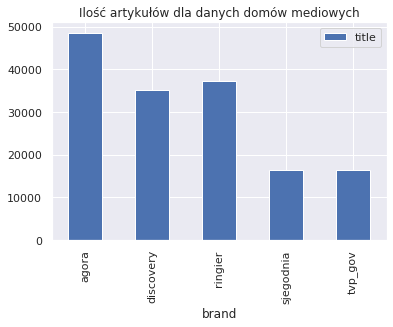

In [8]:
df\
    [['brand', 'title']]\
    .groupby('brand')\
    .count()\
    .plot(kind = 'bar', title = 'Ilość artykułów dla danych domów mediowych')

# Analyze

## Word2Vec

In [9]:
df['whole_string'] = (
    df['title'] + '. ' +
    df['short'] + '. ' +
    df['long']
)

In [10]:
def make_sentences(df):
    sentences = []
    for record in df['whole_string'].dropna().str.lower():
        if record != None:
            for sentence in record.split('.'):
                sentences.append(re.sub(r'\W+', ' ', sentence).lower().strip().split(' '))
    return sentences

In [31]:
models = {}
models['global'] = Word2Vec(make_sentences(df), size = 100, min_count = 7, window = 6, workers = 10)
for brand_name in df['brand'].unique():
    print(brand_name)
    brand_data = make_sentences(df[df['brand'] == brand_name])
    models[brand_name] = Word2Vec(brand_data, size = 100, min_count = 7, window = 6, workers = 10)

discovery
sjegodnia
agora
tvp_gov
ringier


In [37]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)
def calculate_angle(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return abs(np.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))))

In [51]:
def calculate_scores(point_of_view, models, selected_keywords):
    model_dict_keys = (
        ('us', 'discovery'),
        ('pl', 'agora'),
        ('de/ch', 'ringier'),
        ('ru', 'sjegodnia'),
        ('pl', 'tvp_gov')
    )
    results = []
    df_idx = []
    for keyword, k_properties in keyword_reference_words.items():
        try:
            if '' not in k_properties['references'] and point_of_view in k_properties['types']:
                row = []
                reference = k_properties['references']
                for model_dict_key in model_dict_keys:
                    # cosine similarity with one reference
#                     keyword_v = models[model_dict_key[0]][model_dict_key[1]]['model'].wv[keyword]
#                     reference_v = models['model'].wv[reference[0]]
#                     score = distance.cosine(keyword_v, reference_v)
                    # cosine similarity with two references
                    keyword_vector = models[model_dict_key[1]].wv[keyword]
                    positive_vector = models['global'].wv[reference[0]]
                    negative_vector = models['global'].wv[reference[1]]
                    positive_angle = calculate_angle(keyword_vector, positive_vector)
                    negative_angle = calculate_angle(keyword_vector, negative_vector)
                    score = positive_angle / (positive_angle+negative_angle)
                    row.append(score)
                results.append(row)
                df_idx.append(keyword)
        except KeyError:
            print(keyword)
    
    tmp_res = pd.DataFrame(results, columns = ['discovery [US]', 'agora [PL]', 'ringier [EU]', 'sjegodnia [RU]', 'TVP [PL]'], index = df_idx)
    return tmp_res[tmp_res.index.isin(selected_keywords)]

In [52]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        std = df[feature_name].std()
        result[feature_name] = (df[feature_name] - min_value) / std #(max_value - min_value)
    return result

feminizm


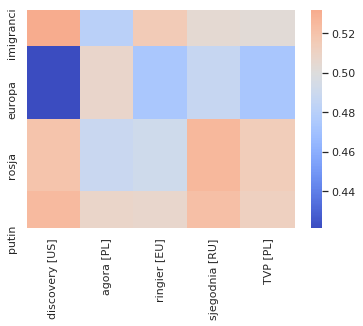

In [56]:
vector_results = calculate_scores('global', models, ['rosja', 'imigranci', 'europa', 'putin'])
sns.heatmap(vector_results, cmap = 'coolwarm', center = 0.5)

In [41]:
models['global'].wv.most_similar('polska')

[('europa', 0.7618128061294556),
 ('rosja', 0.7418935298919678),
 ('ukraina', 0.7406814098358154),
 ('bułgaria', 0.6559218168258667),
 ('ameryka', 0.6522462368011475),
 ('grecja', 0.6384208798408508),
 ('gruzja', 0.6291079521179199),
 ('niepodległa', 0.6266262531280518),
 ('serbia', 0.6224954128265381),
 ('francja', 0.6197077035903931)]

In [110]:
with open('/home/jacek/models', 'wb') as f:
    pickle.dump(models, f)

In [111]:
with open('/home/jacek/models', 'rb') as f:
    models = pickle.load(f)

## Difference in keyword and reference vectors across brands

In [66]:
reference_words = list(set([
    x 
    for y in
    [
        i['references']
        for k, i in
        keyword_reference_words.items()
    ]
    for x in
    y
    if x != ''
]))

In [84]:
keywords = [
    k
    for k, i in
    keyword_reference_words.items()
]

In [136]:
model_words = list(models['sjegodnia'].wv.vocab)

In [92]:
brands = ['discovery', 'sjegodnia', 'agora', 'tvp_gov', 'ringier', 'global']

In [96]:
brands_comb = list(combinations(brands, 2))

- Dla wszystkich kombinacji par domów mediowych:
    - Dla każdego słowa kluczowego/odniesienia:
        - Oblicz różnicę dla tego słowa w wektorach dla różnych domach mediowych
        - Oblicz przeciętnie jak bardzo wartości w wektorze różnią się pomiędzy domami mediowymi
    - Oblicz średnią dla wszystkich wyliczonych słów dla danej pary domów mediowych
- Wylicz średnią dla wszystkich par
- Porównaj, o ile mocniej wektory różnią się pomiędzy sobą w grupie wyrazów kluczowych i wyrazów odniesień

In [112]:
def get_avg_diff(words):
    return np.array([
        np.array([
            np.array((abs(models[a].wv[word] - models[b].wv[word]))).mean()
            for word in
            words
            if word in models[a].wv.vocab and word in models[b].wv.vocab
        ]).mean()
        for a, b in
        brands_comb
    ]).mean()

In [114]:
get_avg_diff(keywords)

1.3579595

In [140]:
get_avg_diff(reference_words)

0.69321465

In [143]:
for i in range(10):
    shuffle(model_words)
    random_words = model_words[:len(reference_words)]
    print(get_avg_diff(random_words))

0.4119489
0.45895344
0.3923192
0.39340314
0.27553144
0.46579668
0.42239007
0.46210945
0.50245064
0.36235622


In [107]:
# Jak widać różnice są dwukrotnie większe wśród wyrazów kluczowych, 
# w porównaniu do słów odniesień lub trzykrotne w porównaniu do innych losowych słów.
# Wygląda na to że różnice w wektorach pomiędzy brandami mają znaczenie

## Obvious patterns

feminizm


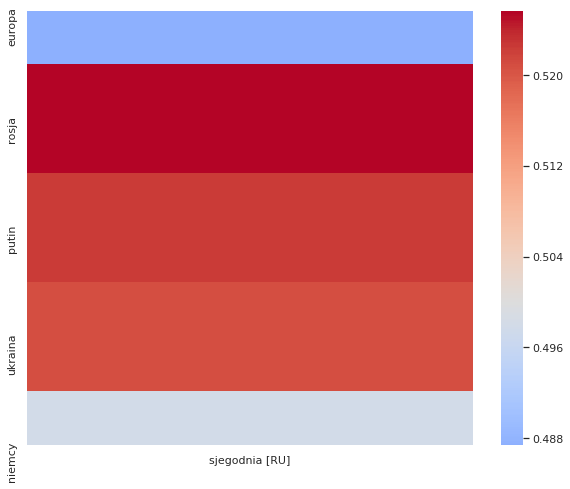

In [151]:
vector_results = calculate_scores('global', models, ['rosja', 'europa', 'putin', 'ukraina', 'niemcy'])
sns.heatmap(vector_results[['sjegodnia [RU]']], cmap = 'coolwarm', center = 0.5)

## Get emotions data from polish wordnet

In [22]:
# http://plwordnet.pwr.wroc.pl//wordnet/download-wordnet?key=1iflsj&file=4.0
# extract one file (słownik_anotacji_emocjonlanej) to home directory

In [152]:
emotions = pd.read_csv('~/słownik_anotacji_emocjonlanej.csv')[['lemat', 'emocje']].dropna()

In [153]:
emotions.head()

,lemat,emocje
2,abstrakcyjny,wstręt;złość;zaskoczenie
3,abstrakcyjny,wstręt;złość
10,adorator,złość;radość
11,adorator,złość;cieszenie się na;radość;wstręt
18,afektowany,złość;smutek


In [154]:
emotions['emocje'] = emotions['emocje'].str.replace(':', ';')

In [155]:
pairs = [
    ('złosć', 'negatywny'),
    ('zlość', 'negatywny'),
    ('złośc', 'negatywny'),
    ('złość wstręt', 'negatywny'),
    ('złość: nieużyteczność', 'negatywny'),
    ('złóść', 'negatywny'),
    ('bład', 'negatywny'),
    ('brzydota', 'negatywny'),
    ('błąd', 'negatywny'),
    ('gniew', 'negatywny'),
    ('krzywda', 'negatywny'),
    ('nieszczęscie', 'negatywny'),
    ('nieszczęście', 'negatywny'),
    ('nieużyteczność', 'negatywny'),
    ('złość', 'negatywny'),
    ('strach', 'negatywny'),
    ('strach wstręt', 'negatywny'),
    ('smute', 'negatywny'),
    ('smutek', 'negatywny'),
    ('wstęt', 'negatywny'),
    ('niewiedza', 'negatywny'),
    ('negatywny wstręt', 'negatywny'),
    ('negatywnyk', 'negatywny'),
    ('negatywnyk: negatywny', 'negatywny'),
    ('wstrę', 'negatywny'),
    ('wstręt', 'negatywny'),
    ('wstręt: negatywny', 'negatywny'),
    ('negatywnyt', 'negatywny'),
    ('s mutek', 'negatywny'),
    ('wstret', 'negatywny'),
    ('smitek', 'negatywny'),
    (' negatywny', 'negatywny'),
    
    ('cieszenie sie', 'pozytywny'),
    ('cieszenie sie na', 'pozytywny'),
    ('cieszenie się na coś oczekiwanego', 'pozytywny'),
    ('dobro', 'pozytywny'),
    ('cieszenie sie', 'pozytywny'),
    ('radoć', 'pozytywny'),
    ('radość', 'pozytywny'),
    ('radość: piękno', 'pozytywny'),
    ('radość: szczęście', 'pozytywny'),
    ('zaufanie', 'pozytywny'),
    ('cieszenie się', 'pozytywny'),
    ('cieszenie się na', 'pozytywny'),
    ('ciesznie się na', 'pozytywny'),
    ('piękno', 'pozytywny'),
    ('pozytywny: piękno', 'pozytywny'),
    ('pozytywny: szczęście', 'pozytywny'),
    ('prawda', 'pozytywny'),
    ('radosć', 'pozytywny'),
    ('pozytywny: pozytywny', 'pozytywny'),
    ('radośc', 'pozytywny'),
    ('szczęście', 'pozytywny'),
    ('użyteczność', 'pozytywny'),
    ('wiedza', 'pozytywny'),
    ('zufanie', 'pozytywny'),
    ('pozytywny na', 'pozytywny'),
    (' pozytywny', 'pozytywny'),
    
    ('zaskoczenie czymś nieprzewidywanym', ''),
    ('oczekiwanie na', ''),
    (' czymś nieprzewidywanym', ''),
    ('-', ''),
    ('zaskoczenie', ''),
    ('pozytywnynegatywny', ''),
]

In [156]:
for pair in pairs:
    emotions['emocje'] = emotions['emocje'].str.replace(pair[0], pair[1])

In [157]:
emotions = pd.concat([
    emotions['lemat'],
    emotions['emocje']\
        .str.get_dummies(sep = ';')\
], axis = 1)

In [158]:
emotions.loc[
    emotions['pozytywny'] == emotions['negatywny']
, 'ambiguous'] = True

In [159]:
len(emotions)

56420

In [160]:
emotions = emotions[emotions['ambiguous'].isna()]
emotions = emotions.drop('ambiguous', axis = 1)

In [161]:
len(emotions)

47477

In [162]:
emotions['negatywny'].sum()

31505

In [163]:
emotions['pozytywny'].sum()

15972

In [164]:
emotions.sample(5).head()

,lemat,negatywny,pozytywny
162853,zrypany,1,0
158506,humanizować się,0,1
29398,literacina,1,0
82735,niesolidarność,1,0
176077,narobić się,1,0


In [165]:
emotions = emotions.drop('negatywny', axis = 1)

In [166]:
emotions.loc[emotions['pozytywny'] == 0, 'pozytywny'] = -1

In [167]:
emotions.columns = ['lemat', 'sentyment']

In [168]:
emotions = emotions.drop_duplicates()

In [169]:
emotions.sample(5).head()

,lemat,sentyment
148581,uparty jak kozioł,-1
123293,egalitarystyczny,1
85822,udany,1
161759,prozwierzęcy,1
52829,nabijać się,-1


In [170]:
emotions_dict = {x[0]:x[1] for x in emotions.values}

## Titles/shorts

In [171]:
emotions.sample(5).head()

,lemat,sentyment
165551,pobiesiadować,1
150883,gównoburza,-1
7702,uprzedzenie,-1
10678,psi grosz,-1
85227,nowiusieńki,1


In [172]:
emotion_words = emotions_dict.keys()

In [173]:
df['sentiment'] = df['long'].str.lower().apply(lambda x: sum([emotions_dict[a] 
                                         for a in str(x).split(' ')
                                         if a in emotion_words]))

In [178]:
grouped_data = {}
for key, grouping_order in grouping_orders.items():
    data_dict = {}
    for keyword in keywords:
        data_dict[keyword] = df\
            [(df[keyword] == 1)&(df['sentiment'] != 0)]\
            [grouping_order['columns_before']]\
            .groupby(grouping_order['groupby'])\
            .mean()\
            .values\
            .flatten()
    res = pd.DataFrame().from_dict(
        data_dict,
        'index',
        columns = grouping_order['columns_after']
    )
    res = (res - res.mean())/res.std()
    grouped_data[key] = res

KeyError: 'najwyższy'

In [176]:
sns.heatmap(grouped_data['brand']);

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [47]:
# compare that chart (two websites in one company), and two websites from two different companies

## Regex

In [180]:
wc = WordCloud()

In [181]:
keyword_patterns = ['duda', 'dudy', 'dude']

In [182]:
found_records = df[['long']][
    df['long'].str.lower().str.contains(r'|'.join(keyword_patterns)) == True
].values.flatten()

In [183]:
keyword_words_before = []
keyword_words_after = []
for record in found_records:
    tmp_string_list = re.sub(r'\W+', ' ', record).lower().split(' ')
    keyword_idxs = [n for n, x in enumerate(tmp_string_list) if x in keyword_patterns]
    max_idx = len(tmp_string_list)
    for keyword_idx in keyword_idxs:
        if keyword_idx < max_idx - 2 and keyword_idx > 1:
            keyword_context_before = tmp_string_list[keyword_idx-2 : keyword_idx]
            keyword_words_before.append(keyword_context_before[0])
            keyword_words_before.append(keyword_context_before[1])
            keyword_context_after = tmp_string_list[keyword_idx+1 : keyword_idx+3]
            keyword_words_after.append(keyword_context_after[0])
            keyword_words_after.append(keyword_context_after[1])

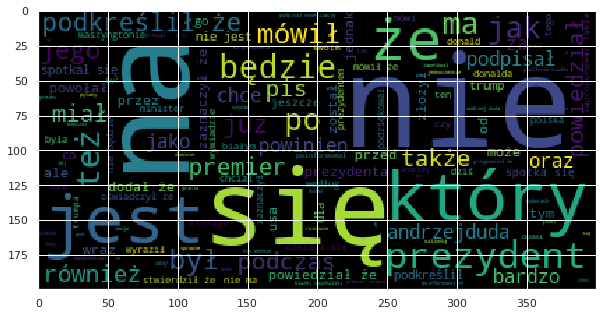

In [184]:
plt.imshow(wc.generate(" ".join(keyword_words_after)))